# Well Multiphase Production Performance Prediction Using Deep Learning 

## Libraries Loading 

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import tensorflow as tf
from sklearn.model_selection import train_test_split
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense, LSTM, CuDNNLSTM, Dropout, Activation,GRU
from sklearn.metrics import mean_squared_error
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler

path = 'plot_DL/F-11/'

Using TensorFlow backend.


##  Data loading and preparation

In [2]:
data =pd.read_excel('data/data_well_f11-select.xlsx', sheet_name= 'Sheet1')

In [3]:
data.head()

,DATEPRD,NPD_WELL_BORE_NAME,ON_STREAM_HRS,AVG_DOWNHOLE_PRESSURE,AVG_DOWNHOLE_TEMPERATURE,AVG_DP_TUBING,AVG_ANNULUS_PRESS,AVG_CHOKE_SIZE_P,AVG_WHP_P,AVG_WHT_P,DP_CHOKE_SIZE,BORE_OIL_VOL,BORE_GAS_VOL,BORE_WAT_VOL,OIL_RATE,GAS_RATE,WAT_RATE,WAT_CUT,TIME
0,2013-07-24,15/9-F-11,7.00000,1.926270,0.352200,26.123040,2.885360,3.256548,28.049310,18.194630,18.851470,17.85,2772.47,0.0,61.200000,9505.611429,0.0,0.0,0
1,2013-07-25,15/9-F-11,24.00000,163.594260,60.315740,61.473080,19.464510,8.549131,102.121180,36.967440,72.955190,725.00,108940.11,0.0,725.000000,108940.110000,0.0,0.0,1
2,2013-07-31,15/9-F-11,5.07514,273.946931,105.551370,179.382345,21.550252,2.540804,94.564586,55.958893,66.403770,190.35,29119.73,0.0,900.152508,137705.269214,0.0,0.0,7
3,2013-08-03,15/9-F-11,15.07486,277.797679,104.933215,181.302141,1.652926,6.116182,96.495539,41.019083,68.441106,590.09,88733.42,0.0,939.455491,141268.448264,0.0,0.0,10
4,2013-08-04,15/9-F-11,24.00000,273.594368,105.439765,177.392876,17.308850,9.951288,96.201492,52.455287,67.943750,1066.46,161227.00,0.0,1066.460000,161227.000000,0.0,0.0,11


* We remove DATEPRD and NPD_WELL_BORE_NAME variables
* We remove also BORE_OIL_VOL, BORE_GAS_VOL, BORE_WAT_VOL since they are used to compute the target variables

In [4]:
Data = data.drop(['ON_STREAM_HRS','DATEPRD', 'NPD_WELL_BORE_NAME','BORE_OIL_VOL','BORE_GAS_VOL','BORE_WAT_VOL', 'WAT_CUT'], axis = 'columns', inplace = False)

### Features selection

The correlation describes the strength of the linear association between two variables. It summarizes the strength and direction of the linear (straight-line) association between two quantitative variables. 

#### Target variables associations: 
    Based on the correlation matrix: 
    - we can notice that 'GAS_RATE' and 'OIL_RATE' variabales are highly correlated; their correlation estimated by 0.97. 
    - 'WAT_RATE' is slightly negatively correlated with the GAS and OIL rates variables.  

,AVG_DOWNHOLE_PRESSURE,AVG_DOWNHOLE_TEMPERATURE,AVG_DP_TUBING,AVG_ANNULUS_PRESS,AVG_CHOKE_SIZE_P,AVG_WHP_P,AVG_WHT_P,DP_CHOKE_SIZE,OIL_RATE,GAS_RATE,WAT_RATE,TIME
AVG_DOWNHOLE_PRESSURE,1.000000,0.281430,0.530942,0.115781,0.064999,0.411334,-0.351974,0.440482,-0.515392,-0.503032,0.005566,-0.110394
AVG_DOWNHOLE_TEMPERATURE,0.281430,1.000000,0.160900,0.111411,-0.032307,0.040079,0.157244,0.010485,0.163254,0.169749,-0.034409,-0.009656
AVG_DP_TUBING,0.530942,0.160900,1.000000,0.013805,0.797255,-0.551502,0.476392,-0.519531,-0.683784,-0.670599,0.815467,0.756992
AVG_ANNULUS_PRESS,0.115781,0.111411,0.013805,1.000000,-0.051261,0.095095,0.021133,0.105095,-0.128727,-0.136273,-0.113162,-0.151645
AVG_CHOKE_SIZE_P,0.064999,-0.032307,0.797255,-0.051261,1.000000,-0.788379,0.732403,-0.760948,-0.430004,-0.416046,0.953161,0.832946
AVG_WHP_P,0.411334,0.040079,-0.551502,0.095095,-0.788379,1.000000,-0.874506,0.997300,0.205867,0.203815,-0.867915,-0.923791
AVG_WHT_P,-0.351974,0.157244,0.476392,0.021133,0.732403,-0.874506,1.000000,-0.874215,0.038984,0.039803,0.798662,0.778631
DP_CHOKE_SIZE,0.440482,0.010485,-0.519531,0.105095,-0.760948,0.997300,-0.874215,1.000000,0.166818,0.165840,-0.844501,-0.914108
OIL_RATE,-0.515392,0.163254,-0.683784,-0.128727,-0.430004,0.205867,0.038984,0.166818,1.000000,0.989640,-0.398099,-0.363629
GAS_RATE,-0.503032,0.169749,-0.670599,-0.136273,-0.416046,0.203815,0.039803,0.165840,0.989640,1.000000,-0.387361,-0.363185


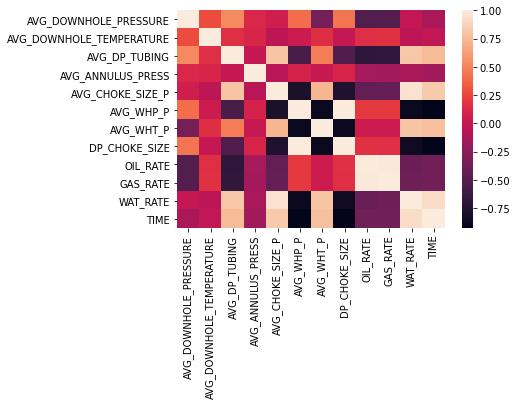

In [5]:
corr = Data.corr()
#corr_data = pd.DataFrame(corr)
sns.heatmap(corr)
corr

* We can see the linear relationship between the OIL and GAS rates using the scatter plot. 

Text(0, 0.5, 'Gas rate')

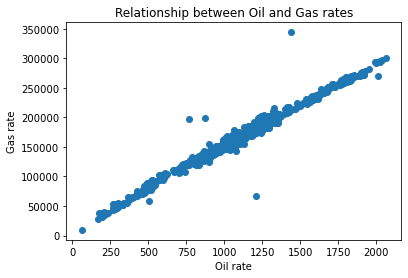

In [6]:
plt.scatter(Data['OIL_RATE'], Data['GAS_RATE'])
plt.title('Relationship between Oil and Gas rates')
plt.xlabel('Oil rate')
plt.ylabel('Gas rate')

* They even share the same distribution, normal distribution with some outliers in the same levels. 
We can conclude that the prediction of one variable implies the other.

<AxesSubplot:>

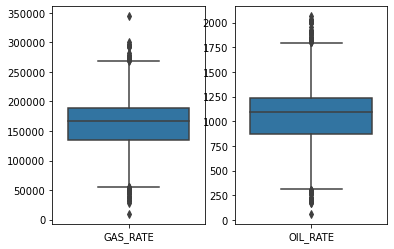

In [7]:
plt.subplot(1, 2, 1)
sns.boxplot( data=Data, order= ['GAS_RATE'])

plt.subplot(1, 2, 2)
sns.boxplot( data=Data, order= ['OIL_RATE'])

#### Predictors relationship with the target variables: 

* In order to avoid multicollinearity, we compare the correlation between features and remove one of two features that have a correlation higher than 0.9


In [8]:
datafeatures = Data.drop(['OIL_RATE', 'GAS_RATE', 'WAT_RATE', 'TIME'], axis = 'columns', inplace = False)
corr = datafeatures.corr()
columns = np.full((corr.shape[0],), True, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] >= 0.9:
            if columns[j]:
                columns[j] = False
print(columns)
selected_columns = datafeatures.columns[columns]
newdata = datafeatures[selected_columns]
newdata['Time'] = Data['TIME']
newdata['OIL_RATE'] = Data['OIL_RATE'] 
newdata['GAS_RATE'] = Data['GAS_RATE'] 
newdata['WAT_RATE'] = Data['WAT_RATE']


[ True  True  True  True  True  True  True False]


In [9]:
newdata.shape

(1115, 11)

In [10]:
newdata.columns

Index(['AVG_DOWNHOLE_PRESSURE', 'AVG_DOWNHOLE_TEMPERATURE', 'AVG_DP_TUBING',
       'AVG_ANNULUS_PRESS', 'AVG_CHOKE_SIZE_P', 'AVG_WHP_P', 'AVG_WHT_P',
       'Time', 'OIL_RATE', 'GAS_RATE', 'WAT_RATE'],
      dtype='object')

### Data Structure: 
* We prepare the data so it can be fed into the neural network models. We'll check first the dimension of the features and targets data. 

In [11]:
newdata.head()
newdata = newdata.dropna()
newdata.shape

(1115, 11)

In [12]:
# Non Array
Features = newdata.iloc[:,:-3]
print('the features data X is of dimension', Features.shape)
Targets = newdata.iloc[:,-3:]
print('the targets data Y is of dimension', Targets.shape)

the features data X is of dimension (1115, 8)
the targets data Y is of dimension (1115, 3)


In [13]:
# Array
features = newdata.iloc[:,:-4].values
print('the features data X is of dimension', features.shape)
targets = newdata.iloc[:,-3:].values
print('the targets data Y is of dimension', targets.shape)

the features data X is of dimension (1115, 7)
the targets data Y is of dimension (1115, 3)


In [14]:
newdata.iloc[:,:-4]

,AVG_DOWNHOLE_PRESSURE,AVG_DOWNHOLE_TEMPERATURE,AVG_DP_TUBING,AVG_ANNULUS_PRESS,AVG_CHOKE_SIZE_P,AVG_WHP_P,AVG_WHT_P
0,1.926270,0.352200,26.123040,2.885360,3.256548,28.049310,18.194630
1,163.594260,60.315740,61.473080,19.464510,8.549131,102.121180,36.967440
2,273.946931,105.551370,179.382345,21.550252,2.540804,94.564586,55.958893
3,277.797679,104.933215,181.302141,1.652926,6.116182,96.495539,41.019083
4,273.594368,105.439765,177.392876,17.308850,9.951288,96.201492,52.455287
...,...,...,...,...,...,...,...
1110,253.399422,105.266981,226.400814,22.564198,100.000000,26.998608,83.820656
1111,253.209915,105.271539,226.255384,22.720235,100.000000,26.954532,84.779993
1112,252.938710,105.274111,226.036656,22.580877,100.000000,26.902054,82.589448
1113,252.892344,105.275896,226.022291,22.570981,100.000000,26.870053,83.607970



A good rule of thumb is that normalized data lead to better performance in Neural Networks. In this project, use MinMaxScaler from sklearn. We apply MinMaxScaler on the data so the high values would not take more attention than the others.



It is important to ensure that the scale of the output variable is in the range 0-1 to match the scale of the activation function (tanh) on the output layer of LSTM/GRU. Also, input variables are better to be small values, probably in the range of 0-1.

What are the steps?

- Fit the scaler using available training data (It means that the minimum and maximum observable values are estimated using training data.)

- Apply the scaler to training data

- Apply the scaler to test data

It is important to note that we should scale the unseen data with the scaler fitted on the training data.

In [15]:
scaler_x = MinMaxScaler()
scaler_y= MinMaxScaler()


x = scaler_x.fit_transform(features)
Y = scaler_y.fit_transform(targets)

* The LSTM model input dimension requires the third dimension that will be the number of the single input row. We'll reshape the X data 

In [16]:
X = x.reshape(x.shape[0], x.shape[1], 1)

* We can split the data into the train, test and validation parts; 70% of the data for training set and the remaining 30% for the testing and validation sets.

**Method 1**

In [17]:
# Method 1
Xtrv, Xtest, Ytrv, Ytest = train_test_split(X,Y,test_size=0.15,train_size=0.85)
Xtrain, Xval, Ytrain, Yval = train_test_split(Xtrv,Ytrv,test_size = 0.15,train_size =0.7)
print('Dimension of data: ',X.shape)
print('Dimension of train data: ',Xtrain.shape)
print('Dimension of test data: ', Xval.shape)
print('Dimension of test data: ', Xtest.shape)
print('Dimension of data (calculated)', Xtrain.shape[0]+ Xval.shape[0]+ Xtest.shape[0])

Dimension of data:  (1115, 7, 1)
Dimension of train data:  (662, 7, 1)
Dimension of test data:  (143, 7, 1)
Dimension of test data:  (168, 7, 1)
Dimension of data (calculated) 973


=========================================================================================================================

**Method 2**

In [18]:
# Method 2
#trv_size = int(len(scaled_data)*0.85)
#train_size = int(len(scaled_data)*0.7)
#val_size = int(len(scaled_data)*0.15)
#train_dataset, val_dataset, test_dataset = scaled_data.iloc[:train_size], scaled_data.iloc[train_size: train_size+val_size], newdata.iloc[train_size+val_size:]
#trv_size =  newdata.iloc[:trv_size]

#print('Dimension of data: ',newdata.shape)
#print('Dimension of train data: ',train_dataset.shape)
#print('Dimension of test data: ', val_dataset.shape)
#print('Dimension of test data: ', test_dataset.shape)
#print('Dimension of data (calculated)', train_dataset.shape[0]+val_dataset.shape[0]+test_dataset.shape[0])

In [19]:
#xtrain, xval, xtest = Features.iloc[:train_size], Features.iloc[train_size: train_size+val_size], Features.iloc[train_size+val_size:]
#ytrain, yval, ytest = Targets.iloc[:train_size], Targets.iloc[train_size: train_size+val_size], Targets.iloc[train_size+val_size:]


#print('Dimension of train data: ',xtrain.shape)
#print('Dimension of test data: ', xval.shape)
#print('Dimension of test data: ', xtest.shape)
#print('Dimension of data (calculated)', xtrain.shape[0]+ xval.shape[0]+ xtest.shape[0])

In [20]:
#train_x_norm, val_x_norm, test_x_norm = scaler_x.fit_transform(xtrain), scaler_x.fit_transform(xval), scaler_x.fit_transform(xtest)
#train_y_norm, val_y_norm, test_y_norm = scaler_y.fit_transform(ytrain), scaler_y.fit_transform(yval), scaler_x.fit_transform(ytest)
#print('Dimension of train data: ',train_x_norm.shape)
#print('Dimension of test data: ', val_x_norm.shape)
#print('Dimension of test data: ', test_x_norm.shape)

In [21]:
#def create_dataset (X, y, time_steps = 1):
#    Xs, ys = [], []
#    
#    for i in range(len(X)-time_steps):
#        v = X[i:i+time_steps, :]
#        Xs.append(v)
#        ys.append(y[i+time_steps])
#        
#    return np.array(Xs), np.array(ys)

In [22]:
#TIME_STEPS = 10
#
#Xtrain, Ytrain = create_dataset(train_x_norm, train_y_norm, TIME_STEPS)
#Xval, Yval = create_dataset(val_x_norm, val_y_norm, TIME_STEPS)
#Xtest, Ytest = create_dataset(test_x_norm, test_y_norm, TIME_STEPS)
#
#print('X_train.shape: ', Xtrain.shape)
#print('y_train.shape: ', Ytrain.shape)
#print('X_val.shape: ', Xval.shape) 
#print('y_val.shape: ', Yval.shape)
#print('X_test.shape: ', Xtest.shape) 
#print('y_test.shape: ', Ytest.shape)

In [23]:
#Xtrain = Xtrain.reshape(Xtrain.shape[0], Xtrain.shape[1], 1)
#Xval = Xval.reshape(Xval.shape[0], Xval.shape[1], 1)
#Xtest = Xtest.reshape(Xtest.shape[0], Xtest.shape[1], 1)
#print('Dimension of train data: ',Xtrain.shape)
#print('Dimension of test data: ', Xval.shape)
#print('Dimension of test data: ', Xtest.shape)

=========================================================================================================================

* Then we will define the input and output data dimensions from X and Y data. Define different scalers for input and output as they have different shapes. This is especially important for using inverse transform function.

In [24]:
input_dimension  = Xtrain.shape[1:]
output_dimension = Ytrain.shape[1]

## Evaluation Metrics

In [25]:
def rae(actual: np.ndarray, predicted: np.ndarray):
    """ Relative Absolute Error """
    return np.sum(np.abs(actual - predicted)) / np.sum(np.abs(actual - np.mean(actual)))

def rse(actual, predicted):
    """ Relative Squared Error """
    return np.sum((predicted - actual)**2) / np.sum((actual - np.mean(actual))**2)

## Modeling

* We will build two neural networks architectures to predict the triplet (OIL_RATE, GAS_RATE, WAT_RATE). 


#### 1. LSTM Model: 

* We will start by defining the sequential model. The sequential model contains LSTM layers with ReLU activations, Dense output layer,  and Adam optimizer with MSE loss function. We will set the input dimension in the first layer and output dimension in the last layer of the model.
* Then, we will fit the model with train data.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128)               66560     
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 387       
Total params: 66,947
Trainable params: 66,947
Non-trainable params: 0
_________________________________________________________________
Train on 662 samples, validate on 143 samples
Epoch 1/100
662/662 [==============================] - 1s 2ms/step - loss: 0.0627 - val_loss: 0.0450
Epoch 2/100
662/662 [==============================] - 1s 1ms/step - loss: 0.0430 - val_loss: 0.0318
Epoch 3/100
662/662 [==============================] - 1s 1ms/step - loss: 0.0254 - val_loss: 0.0134
Epoch 4/100
662/662 [==============================] - 1s 1ms/step - loss: 0.0157 - val_loss: 0.0097
Epoch 5/100
662/662 [==============================] - 1s 1ms/

662/662 [==============================] - 1s 988us/step - loss: 0.0030 - val_loss: 0.0020
Epoch 75/100
662/662 [==============================] - 1s 987us/step - loss: 0.0027 - val_loss: 0.0022
Epoch 76/100
662/662 [==============================] - 1s 981us/step - loss: 0.0028 - val_loss: 0.0023
Epoch 77/100
662/662 [==============================] - 1s 982us/step - loss: 0.0028 - val_loss: 0.0028
Epoch 78/100
662/662 [==============================] - 1s 976us/step - loss: 0.0027 - val_loss: 0.0021
Epoch 79/100
662/662 [==============================] - 1s 984us/step - loss: 0.0029 - val_loss: 0.0021
Epoch 80/100
662/662 [==============================] - 1s 989us/step - loss: 0.0028 - val_loss: 0.0024
Epoch 81/100
662/662 [==============================] - 1s 987us/step - loss: 0.0029 - val_loss: 0.0022
Epoch 82/100
662/662 [==============================] - 1s 981us/step - loss: 0.0029 - val_loss: 0.0021
Epoch 83/100
662/662 [==============================] - 1s 984us/step - loss:

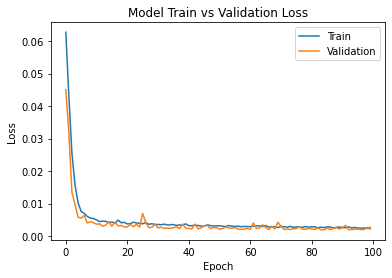

In [26]:
from keras import optimizers

#optimizer = optimizers.Adam(clipvalue=1.e-10)

model = Sequential()
model.add(LSTM(128, input_shape=input_dimension, activation="relu"))
model.add(Dense(output_dimension))
model.compile(loss="mse", optimizer="adam") 
model.summary()
history = model.fit(Xtrain, Ytrain, batch_size=5, validation_data=(Xval, Yval), epochs=100)
pyplot.plot(history.history['loss'])
pyplot.plot(history.history['val_loss'])
pyplot.title('Model Train vs Validation Loss')
pyplot.ylabel('Loss')
pyplot.xlabel('Epoch')
pyplot.legend(['Train', 'Validation'], loc='upper right')
pyplot.show()

#### Testing Overfitting and Underfitting: 
* To test if our model overfitting or underfitted on the data sample, we use the traning and validation sets 
* Based on the loss function plot of  training and validation sets, we can notice that the loss decreases until the 60th epoch

* We train the model and then we test it on the testing data.

In [27]:
model = Sequential()
model.add(LSTM(128, input_shape=input_dimension, activation="relu"))
model.add(Dense(output_dimension))
model.compile(loss="mse", optimizer="adam") 
model.summary()
history = model.fit(Xtrain, Ytrain, batch_size=5, epochs=70, verbose = 0)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 128)               66560     
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 387       
Total params: 66,947
Trainable params: 66,947
Non-trainable params: 0
_________________________________________________________________


#### Results prediction and visualization :

* We will predict test data and we check the mean squared error (MSE), the relative squared error (RSE) and the relative abolute error (RAE).

In [38]:
predictionsLSTM = model.predict(Xtest)

* We plot the result of predictions in the following graph by doing inversion first: 

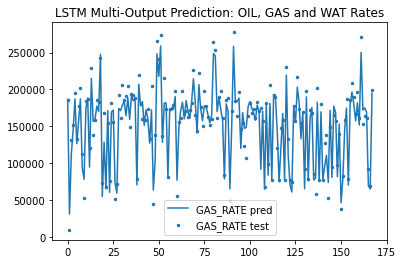

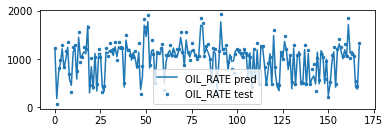

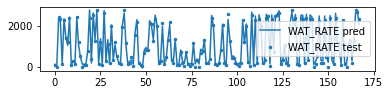

In [39]:
Predictionsinversed = scaler_y.inverse_transform(predictionsLSTM)
Ytestinversed = scaler_y.inverse_transform(Ytest)

axis = range(len(Xtest))
plt.subplot(1, 1, 1)
plt.title("LSTM Multi-Output Prediction: OIL, GAS and WAT Rates")
plt.scatter(axis, Ytestinversed[:,1],  s=6, label="GAS_RATE test")
plt.plot(axis, Predictionsinversed[:,1], label="GAS_RATE pred")

plt.legend()
plt.show()
plt.subplot(2, 1, 1)
plt.scatter(axis, Ytestinversed[:,0],  s=6, label="OIL_RATE test")
plt.plot(axis, Predictionsinversed[:,0], label="OIL_RATE pred")
plt.legend()
plt.show()
plt.subplot(3, 1, 1)
plt.scatter(axis, Ytestinversed[:,2],  s=6, label="WAT_RATE test")
plt.plot(axis, Predictionsinversed[:,2], label="WAT_RATE pred")

plt.legend()
plt.show()

##### RAE and RSE Test

In [40]:
print("Relative Absolute Error metric using LSTM model")

print("OIL_RATE RAE:%.4f" % rae(Ytestinversed[:,0], Predictionsinversed[:,0]))
print("GAS_RATE RAE:%.4f" % rae(Ytestinversed[:,1], Predictionsinversed[:,1])) 
print("WAT_RATE RAE:%.4f" % rae(Ytestinversed[:,2], Predictionsinversed[:,2]))

print('\n')
print("Relative Squared Error metric using LSTM model")

print("OIL_RATE RSE:%.4f" % rse(Ytestinversed[:,0], Predictionsinversed[:,0]))
print("GAS_RATE RSE:%.4f" % rse(Ytestinversed[:,1], Predictionsinversed[:,1])) 
print("WAT_RATE RSE:%.4f" % rse(Ytestinversed[:,2], Predictionsinversed[:,2]))

Relative Absolute Error metric using LSTM model
OIL_RATE RAE:0.3115
GAS_RATE RAE:0.3127
WAT_RATE RAE:0.0978


Relative Squared Error metric using LSTM model
OIL_RATE RSE:0.0885
GAS_RATE RSE:0.0972
WAT_RATE RSE:0.0125


#### Full Visualization: LSTM

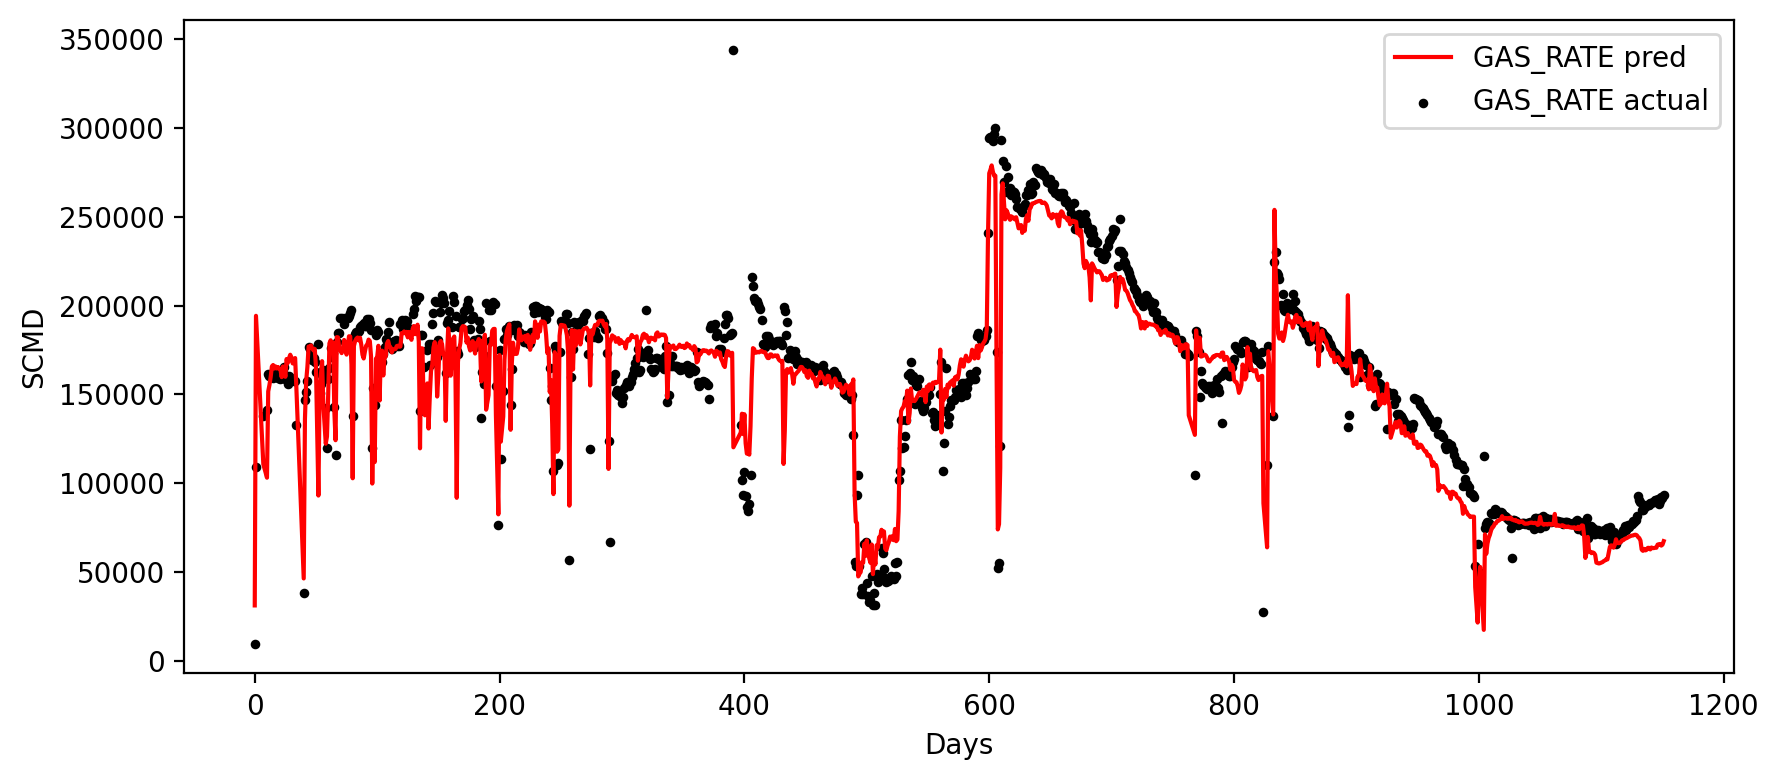

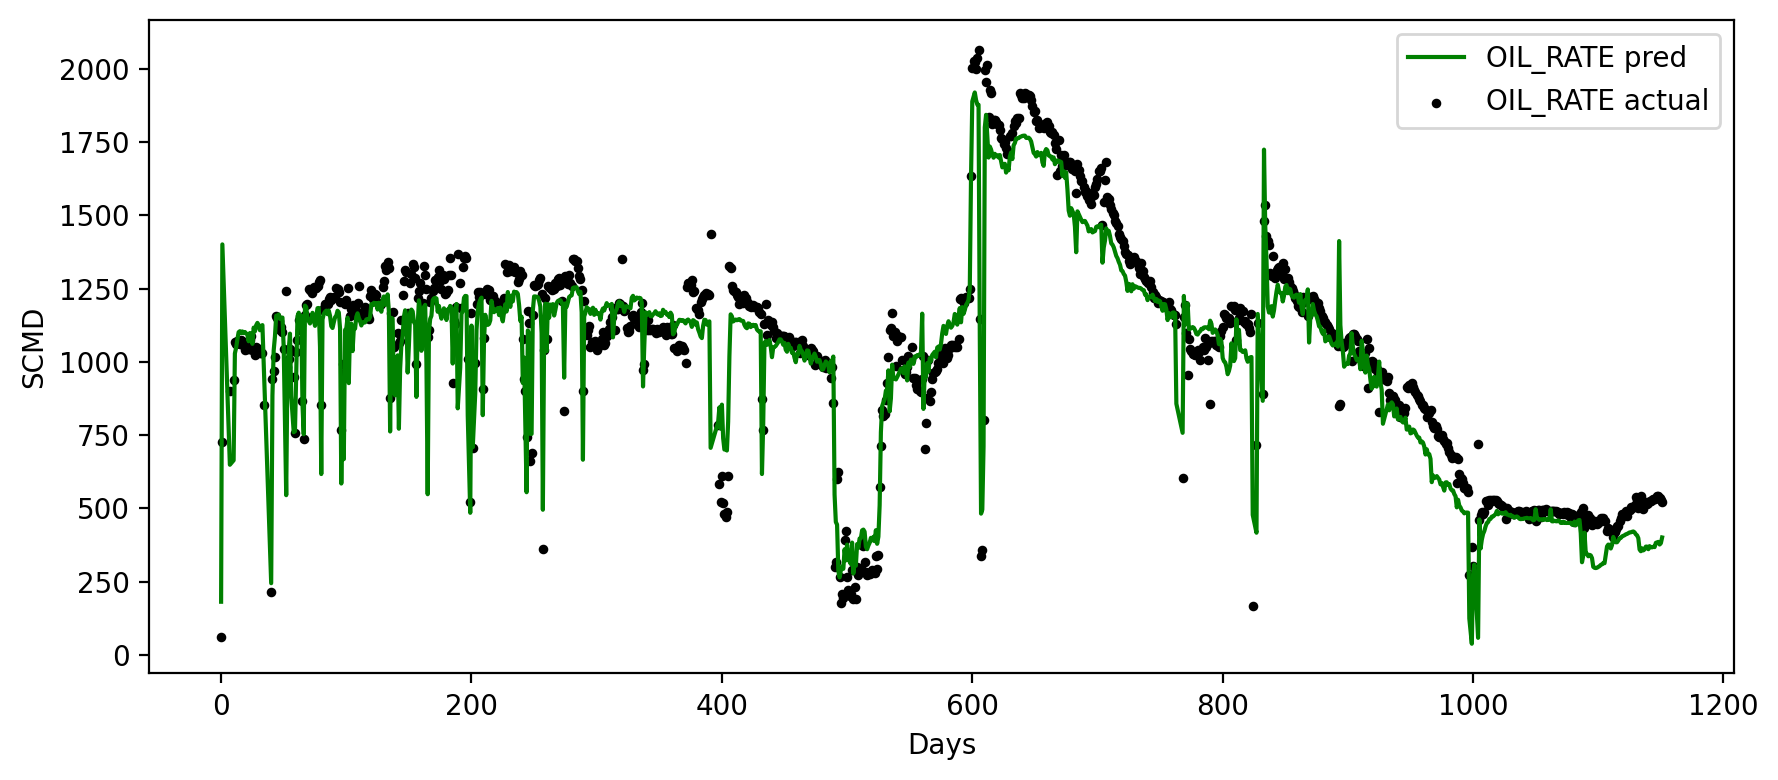

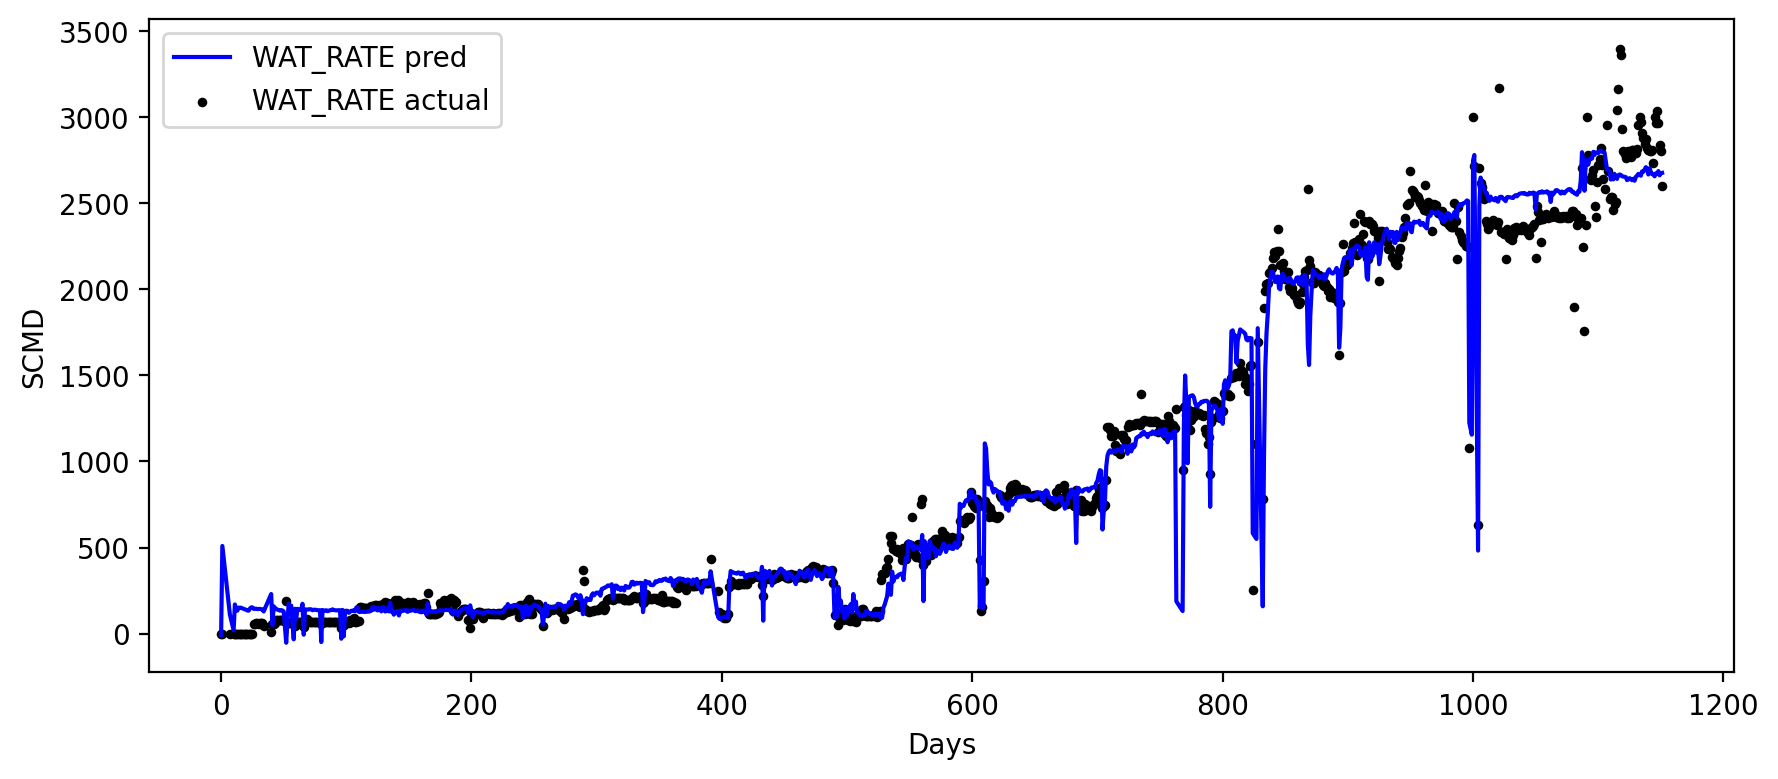

In [31]:
predictionsLSTM = model.predict(X)
Predictionsinversed = scaler_y.inverse_transform(predictionsLSTM)
Ytestinversed = scaler_y.inverse_transform(Y)

axis = newdata.iloc[:,-4].values
plt.figure(figsize=(9, 4), dpi=200)
# plt.scatter(axis, Ytestinversed[:,1],  s=6, c='r', label="GAS_RATE actual")
plt.scatter(axis, targets[:,1],  s=6, c='k', label="GAS_RATE actual")
plt.plot(axis, Predictionsinversed[:,1], 'r', label="GAS_RATE pred")
plt.legend()
plt.xlabel('Days')
plt.ylabel('SCMD')
plt.tight_layout()
exported = ('GAS RATE_LSTM' + '.png')
plt.savefig(path + exported)
plt.show()

#plt.subplot(2, 1, 1)
plt.figure(figsize=(9, 4), dpi=200)
# plt.scatter(axis, Ytestinversed[:,0],  s=6,c='r', label="OIL_RATE actual")
plt.scatter(axis, targets[:,0],  s=6, c='k', label="OIL_RATE actual")
plt.plot(axis, Predictionsinversed[:,0], 'g' , label="OIL_RATE pred")
plt.legend()
plt.xlabel('Days')
plt.ylabel('SCMD')
plt.tight_layout()
exported = ('OIL RATE_LSTM' + '.png')
plt.savefig(path + exported)
plt.show()

#plt.subplot(3, 1, 1)
plt.figure(figsize=(9, 4), dpi=200)
# plt.scatter(axis, Ytestinversed[:,2],  s=6, c='r', label="WAT_RATE actual")
plt.scatter(axis, targets[:,2],  s=6, c='k', label="WAT_RATE actual")
plt.plot(axis, Predictionsinversed[:,2], 'b',label="WAT_RATE pred")
plt.legend()
plt.xlabel('Days')
plt.ylabel('SCMD')
plt.tight_layout()
exported = ('WATER RATE_LSTM' + '.png')
plt.savefig(path + exported)
plt.show()

#### 2. GRU Model
* Based on the history plot, we set the epoch parameter to 65

Train on 662 samples, validate on 143 samples
Epoch 1/100
662/662 [==============================] - 1s 2ms/step - loss: 0.0609 - val_loss: 0.0438
Epoch 2/100
662/662 [==============================] - 1s 1ms/step - loss: 0.0431 - val_loss: 0.0141
Epoch 3/100
662/662 [==============================] - 1s 1ms/step - loss: 0.0189 - val_loss: 0.0098
Epoch 4/100
662/662 [==============================] - 1s 1ms/step - loss: 0.0167 - val_loss: 0.0124
Epoch 5/100
662/662 [==============================] - 1s 1ms/step - loss: 0.0133 - val_loss: 0.0095
Epoch 6/100
662/662 [==============================] - 1s 1ms/step - loss: 0.0125 - val_loss: 0.0075
Epoch 7/100
662/662 [==============================] - 1s 1ms/step - loss: 0.0107 - val_loss: 0.0072
Epoch 8/100
662/662 [==============================] - 1s 1ms/step - loss: 0.0097 - val_loss: 0.0056
Epoch 9/100
662/662 [==============================] - 1s 1ms/step - loss: 0.0097 - val_loss: 0.0060
Epoch 10/100
662/662 [=======================

Epoch 81/100
662/662 [==============================] - 1s 1ms/step - loss: 0.0025 - val_loss: 0.0016
Epoch 82/100
662/662 [==============================] - 1s 1ms/step - loss: 0.0024 - val_loss: 0.0019
Epoch 83/100
662/662 [==============================] - 1s 1ms/step - loss: 0.0024 - val_loss: 0.0016
Epoch 84/100
662/662 [==============================] - 1s 1ms/step - loss: 0.0026 - val_loss: 0.0023
Epoch 85/100
662/662 [==============================] - 1s 1ms/step - loss: 0.0028 - val_loss: 0.0017
Epoch 86/100
662/662 [==============================] - 1s 1ms/step - loss: 0.0024 - val_loss: 0.0016
Epoch 87/100
662/662 [==============================] - 1s 1ms/step - loss: 0.0021 - val_loss: 0.0019
Epoch 88/100
662/662 [==============================] - 1s 1ms/step - loss: 0.0024 - val_loss: 0.0024
Epoch 89/100
662/662 [==============================] - 1s 1ms/step - loss: 0.0025 - val_loss: 0.0021
Epoch 90/100
662/662 [==============================] - 1s 1ms/step - loss: 0.0025

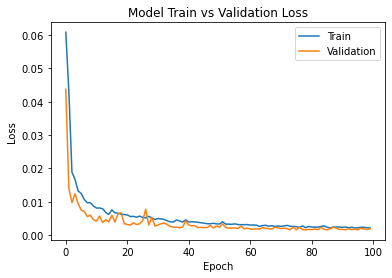

In [32]:
# scaler_x = MinMaxScaler()
# scaler_y= MinMaxScaler()

# x = scaler_x.fit_transform(features)
# Y = scaler_y.fit_transform(targets)
# X = x.reshape(x.shape[0], x.shape[1], 1)

# Xtrv, Xtest, Ytrv, Ytest = train_test_split(X,Y,test_size=0.15,train_size=0.85)
# Xtrain, Xval, Ytrain, Yval = train_test_split(Xtrv,Ytrv,test_size = 0.15,train_size =0.7)

# input_dimension  = Xtrv.shape[1:]
# output_dimension = Ytrv.shape[1]

modelGRU = Sequential()
modelGRU.add(GRU(units=128, input_shape=input_dimension, return_sequences=False))
modelGRU.add(Activation('relu'))
modelGRU.add(Dropout(0.2))
modelGRU.add(Dense(output_dimension))
modelGRU.add(Activation('linear'))
modelGRU.compile(loss='mse', optimizer='adam')
history = modelGRU.fit(Xtrain, Ytrain, batch_size=5, validation_data=(Xval, Yval), epochs=100)
pyplot.plot(history.history['loss'])
pyplot.plot(history.history['val_loss'])
pyplot.title('Model Train vs Validation Loss')
pyplot.ylabel('Loss')
pyplot.xlabel('Epoch')
pyplot.legend(['Train', 'Validation'], loc='upper right')
pyplot.show()

In [33]:
modelGRU = Sequential()
modelGRU.add(GRU(units=128, input_shape=input_dimension, return_sequences=False))
modelGRU.add(Activation('relu'))
modelGRU.add(Dropout(0.2))
modelGRU.add(Dense(output_dimension))
modelGRU.add(Activation('linear'))
modelGRU.compile(loss='mse', optimizer='adam')
modelGRU.fit(Xtrain, Ytrain, batch_size=5, validation_data=(Xval, Yval),epochs=65, verbose=0)

predictions = modelGRU.predict(Xtest)

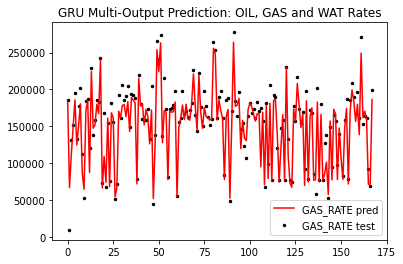

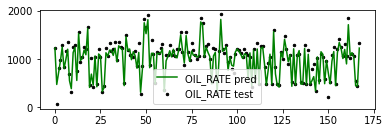

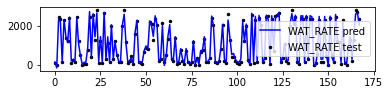

In [34]:
Predictionsinversed = scaler_y.inverse_transform(predictions)
Ytestinversed = scaler_y.inverse_transform(Ytest)

axis = range(len(Xtest))
plt.subplot(1, 1, 1)
plt.title("GRU Multi-Output Prediction: OIL, GAS and WAT Rates")
plt.scatter(axis, Ytestinversed[:,1],  s=6, c='k', label="GAS_RATE test")
plt.plot(axis, Predictionsinversed[:,1], 'r', label="GAS_RATE pred")


plt.legend()
plt.show()
plt.subplot(2, 1, 1)
plt.scatter(axis, Ytestinversed[:,0],  s=6, c='k', label="OIL_RATE test")
plt.plot(axis, Predictionsinversed[:,0], 'g', label="OIL_RATE pred")
plt.legend()
plt.show()

plt.subplot(3, 1, 1)
plt.scatter(axis, Ytestinversed[:,2],  s=6, c='k', label="WAT_RATE test")
plt.plot(axis, Predictionsinversed[:,2], 'b', label="WAT_RATE pred")
plt.legend()
plt.show()

In [35]:
print("Relative Absolute Error metric using GRU model")

print("OIL_RATE RAE:%.4f" % rae(Ytestinversed[:,0], Predictionsinversed[:,0]))
print("GAS_RATE RAE:%.4f" % rae(Ytestinversed[:,1], Predictionsinversed[:,1])) 
print("WAT_RATE RAE:%.4f" % rae(Ytestinversed[:,2], Predictionsinversed[:,2]))

print('\n')
print("Relative Squared Error metric using GRU model")

print("OIL_RATE RSE:%.4f" % rse(Ytestinversed[:,0], Predictionsinversed[:,0]))
print("GAS_RATE RSE:%.4f" % rse(Ytestinversed[:,1], Predictionsinversed[:,1])) 
print("WAT_RATE RSE:%.4f" % rse(Ytestinversed[:,2], Predictionsinversed[:,2]))

Relative Absolute Error metric using GRU model
OIL_RATE RAE:0.2719
GAS_RATE RAE:0.2981
WAT_RATE RAE:0.0900


Relative Squared Error metric using GRU model
OIL_RATE RSE:0.0919
GAS_RATE RSE:0.1067
WAT_RATE RSE:0.0110


#### Full Visualization: GRU

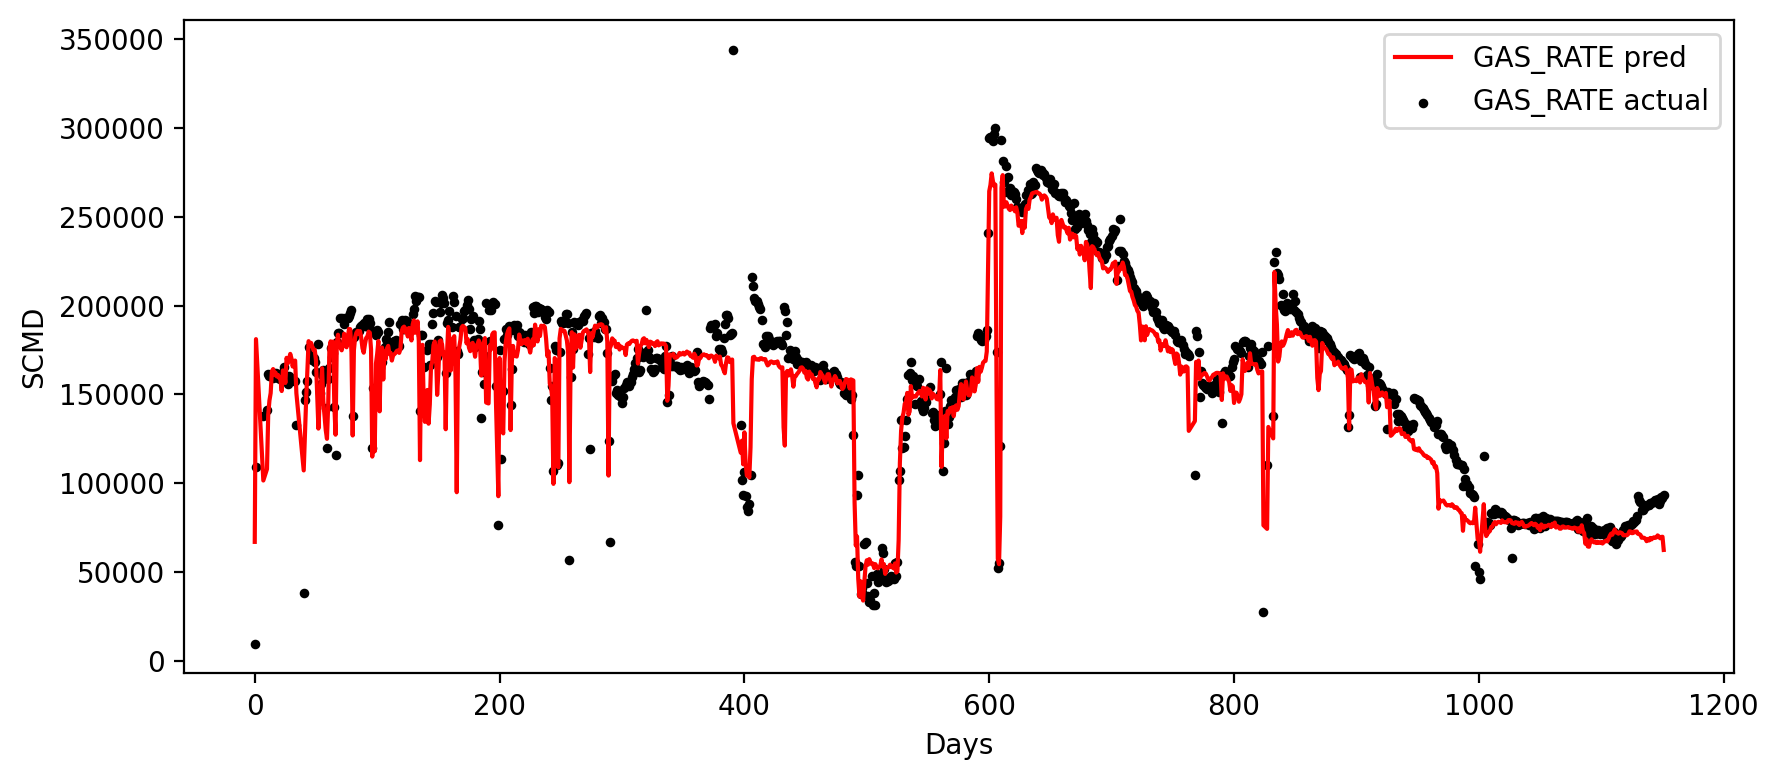

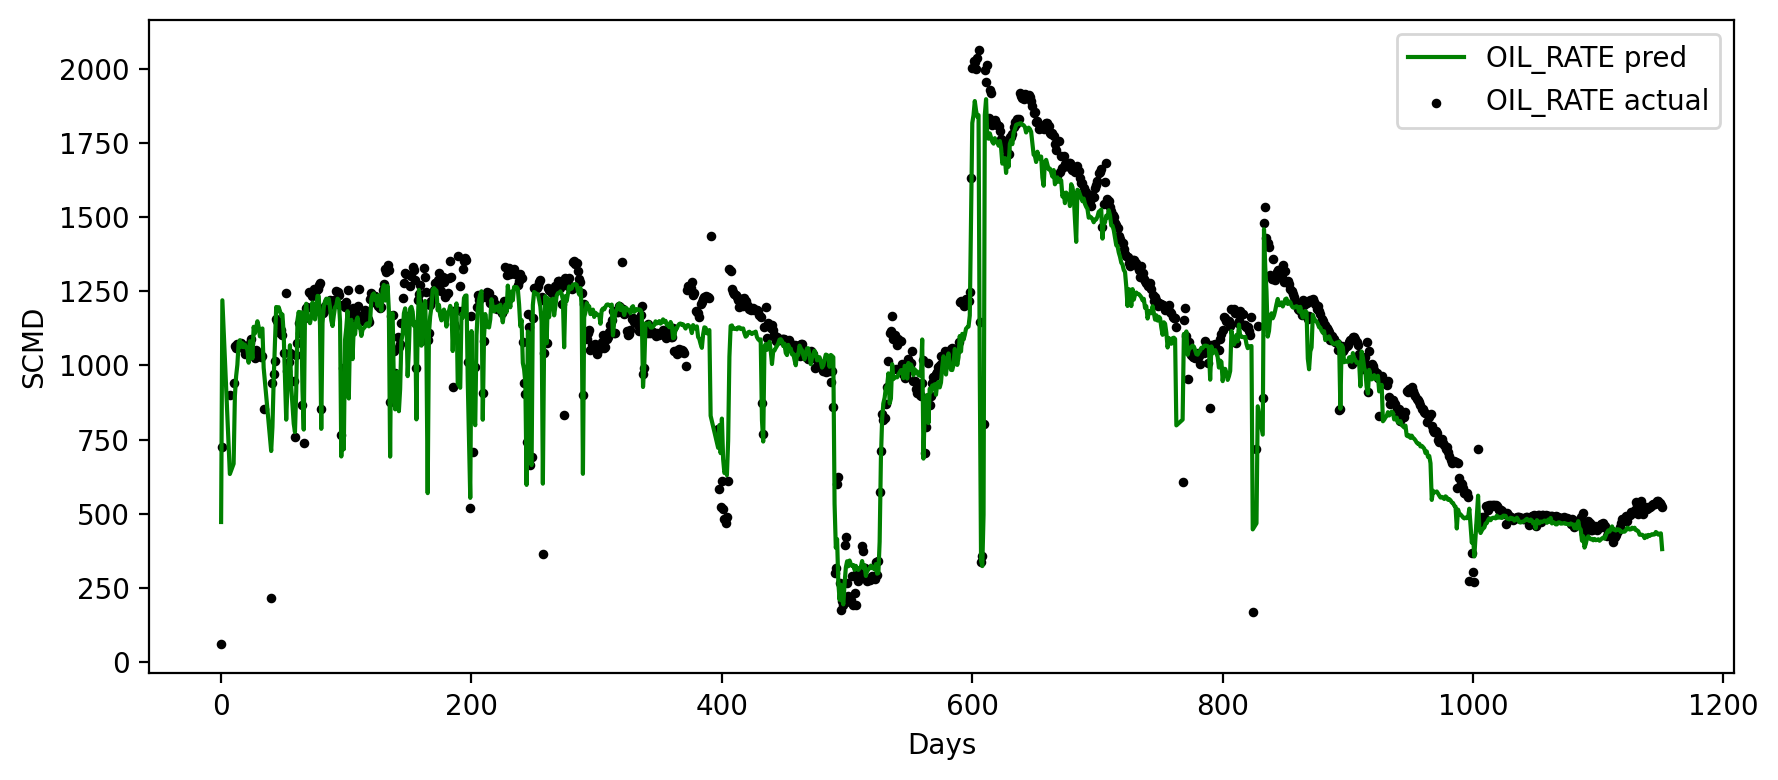

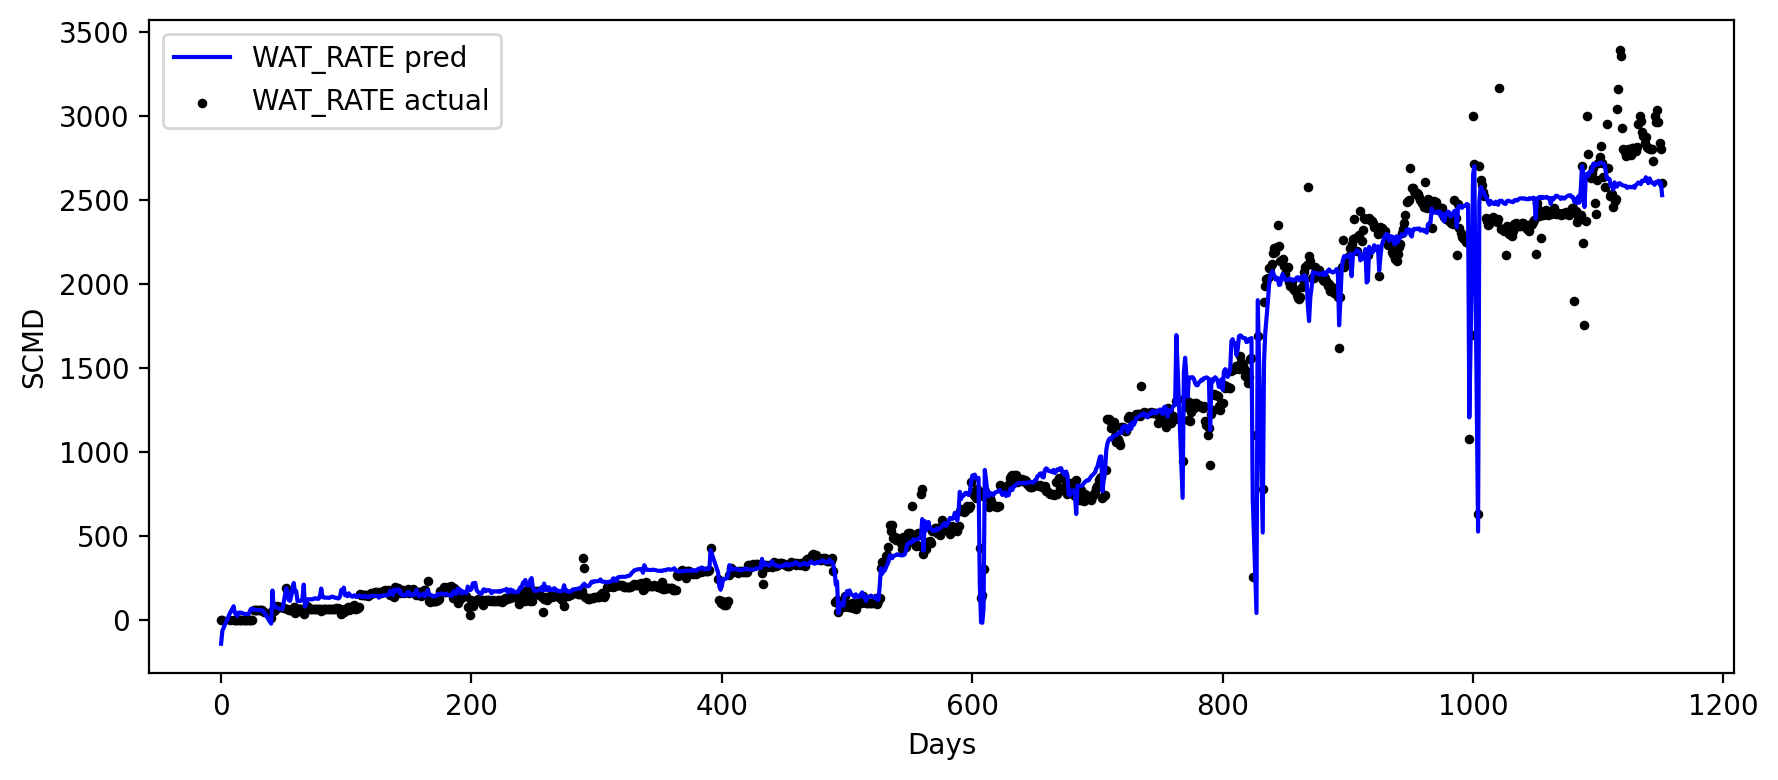

In [37]:
predictions = modelGRU.predict(X)

Predictionsinversed = scaler_y.inverse_transform(predictions)
#Ytestinversed = scaler_y.inverse_transform(Y)


axis = newdata.iloc[:,-4].values
#plt.subplot(1, 1, 1)
# plt.title("GRU Multi-Output Prediction: OIL, GAS and WAT Rates")
plt.figure(figsize=(9,4), dpi=200)
# plt.scatter(axis, Ytestinversed[:,1],  s=6, c='r', label="GAS_RATE actual")
plt.scatter(axis, targets[:,1],  s=6, c='k', label="GAS_RATE actual")
plt.plot(axis, Predictionsinversed[:,1], 'r', label="GAS_RATE pred")
plt.legend()
plt.xlabel('Days')
plt.ylabel('SCMD')
plt.tight_layout()
exported = ('GAS RATE_GRU' + '.png')
plt.savefig(path + exported)
plt.show()

#plt.subplot(2, 1, 1)
plt.figure(figsize=(9,4), dpi=200)
# plt.scatter(axis, Ytestinversed[:,0],  s=6,c='r', label="OIL_RATE actual")
plt.scatter(axis, targets[:,0],  s=6, c='k', label="OIL_RATE actual")
plt.plot(axis, Predictionsinversed[:,0], 'g' , label="OIL_RATE pred")
plt.legend()
plt.xlabel('Days')
plt.ylabel('SCMD')
plt.tight_layout()
exported = ('OIL RATE_GRU' + '.png')
plt.savefig(path + exported)
plt.show()

#plt.subplot(3, 1, 1)
plt.figure(figsize=(9, 4), dpi=200)
# plt.scatter(axis, Ytestinversed[:,2],  s=6, c='r', label="WAT_RATE actual")
plt.scatter(axis, targets[:,2],  s=6, c='k', label="WAT_RATE actual")
plt.plot(axis, Predictionsinversed[:,2], 'b',label="WAT_RATE pred")
plt.legend()
plt.xlabel('Days')
plt.ylabel('SCMD')
plt.tight_layout()
exported = ('WATER RATE_GRU' + '.png')
plt.savefig(path + exported)
plt.show()

## Conclusion: 

We can assume that scaling the data is a crucial step the data preprocessing. Both of the models give good results after scaling using MinMaxScaler() function. However, we can notice that GRU results are slightly better than LSTM model especially if we compare RAE metric. 

**1. Relative Absolute Error metric:**

LSTM model
   * OIL_RATE RAE:0.3115
   * GAS_RATE RAE:0.3127
   * WAT_RATE RAE:0.0978


GRU model
   * OIL_RATE RAE:0.2719
   * GAS_RATE RAE:0.2981
   * WAT_RATE RAE:0.0900




**2. Relative Squared Error metric:** 

LSTM model
   * OIL_RATE RSE:0.0885
   * GAS_RATE RSE:0.0972
   * WAT_RATE RSE:0.0125

GRU model
   * OIL_RATE RSE:0.0919
   * GAS_RATE RSE:0.1067
   * WAT_RATE RSE:0.0110|